In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
file_path = "yield_data.csv"
df = pd.read_csv(file_path)
df.head()

,Crop,Year,Season,District,Area,Production
0,Tomato,2001,Yala,Colombo,0.00,1.00
1,Tomato,2001,Yala,Gampaha,0.00,1.00
2,Tomato,2001,Yala,Kaluthara,NaN,NaN
3,Tomato,2001,Yala,Kandy,292.00,1556.00
4,Tomato,2001,Yala,Matale,473.00,4356.00


In [3]:
# Sort dataset by Year and reset the index
df_sorted = df.sort_values(by='Year').reset_index(drop=True)

In [4]:
# Check for missing values
missing_values = df_sorted.isnull().sum()

# Display columns with missing values
print("Missing Values in Dataset:")
print(missing_values[missing_values > 0])

Missing Values in Dataset:
Area          571
Production    578
dtype: int64


In [5]:
# Fill missing values with 0
df_sorted.fillna(0, inplace=True)

In [6]:
# Check for missing values
missing_values = df_sorted.isnull().sum()

# Display columns with missing values
print("Missing Values in Dataset:")
print(missing_values[missing_values > 0])

Missing Values in Dataset:
Series([], dtype: int64)


In [7]:
# Convert Area and Production to numeric values
df_sorted['Area'] = pd.to_numeric(df_sorted['Area'], errors='coerce')
df_sorted['Production'] = pd.to_numeric(df_sorted['Production'], errors='coerce')

In [8]:
# Create 'Yield_per_Area' column
df_sorted['Yield_per_Area(MT/H)'] = df_sorted.apply(lambda row: row['Production'] / row['Area'] if row['Area'] > 0 else 0, axis=1)

# Remove 'Production' since we're predicting yield per area
df_sorted.drop(columns=['Production'], inplace=True)

df_sorted.head()

,Crop,Year,Season,District,Area,Yield_per_Area(MT/H)
0,Orange,2000,Year,Anuradhapura,221.0,5.411765
1,Orange,2000,Year,Hanbantota,93.0,4.838710
2,Orange,2000,Year,Jaffna,33.0,1.030303
3,Orange,2000,Year,Mannar,4.0,4.500000
4,Orange,2000,Year,Vavuniya,15.0,7.266667


In [9]:
# Check min and max values
max_area = df_sorted['Area'].max()
min_area = df_sorted['Area'].min()

max_yield = df_sorted['Yield_per_Area(MT/H)'].max()
min_yield = df_sorted['Yield_per_Area(MT/H)'].min()

print(f"Max Area: {max_area} hectares")
print(f"Min Area: {min_area} hectares")
print(f"Max Yield per Hectare: {max_yield} metric tons/hectare")
print(f"Min Yield per Hectare: {min_yield} metric tons/hectare")

Max Area: 44799.7 hectares
Min Area: 0.0 hectares
Max Yield per Hectare: 391.5 metric tons/hectare
Min Yield per Hectare: 0.0 metric tons/hectare


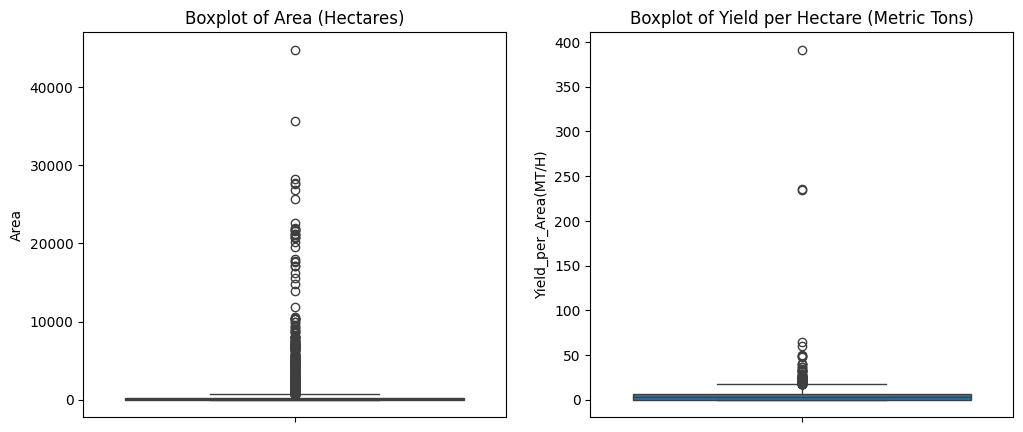

In [10]:
#Boxplot of Area and Yield per Hectare
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_sorted['Area'])
plt.title("Boxplot of Area (Hectares)")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_sorted['Yield_per_Area(MT/H)'])
plt.title("Boxplot of Yield per Hectare (Metric Tons)")

plt.show()

In [11]:
# Remove outliers
df_sorted = df_sorted[df_sorted['Area'] <= 30000]
df_sorted = df_sorted[df_sorted['Yield_per_Area(MT/H)'] <= 100]

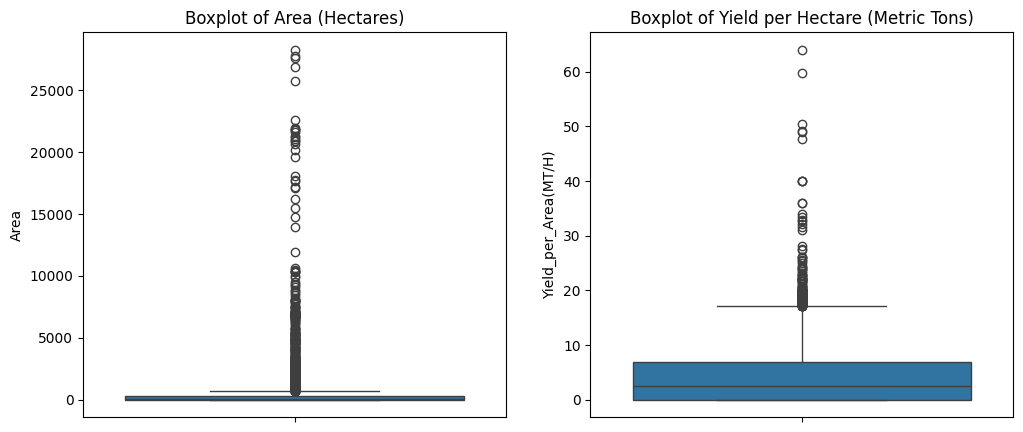

In [12]:
#Boxplot of Area and Yield per Hectare
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_sorted['Area'])
plt.title("Boxplot of Area (Hectares)")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_sorted['Yield_per_Area(MT/H)'])
plt.title("Boxplot of Yield per Hectare (Metric Tons)")

plt.show()

In [13]:
# Encode categorical features
label_encoders = {}
label_mappings = {}
for col in ['Crop', 'Season', 'District']:
    le = LabelEncoder()
    df_sorted[col] = le.fit_transform(df_sorted[col])
    label_encoders[col] = le  # Store encoders for later use
    # Store label mapping
    label_mappings[col] = {class_name: idx for idx, class_name in enumerate(le.classes_)}

In [14]:
print("\nLabel Encodings for Categorical Columns:")
pprint.pprint(label_mappings)


Label Encodings for Categorical Columns:
{'Crop': {'Maize': 0, 'Orange': 1, 'Pepper': 2, 'Potato': 3, 'Tomato': 4},
 'District': {'Ampara': 0,
              'Anuradhapura': 1,
              'Badulla': 2,
              'Batticaloa': 3,
              'Colombo': 4,
              'Galle': 5,
              'Gampaha': 6,
              'Hanbantota': 7,
              'Jaffna': 8,
              'Kaluthara': 9,
              'Kandy': 10,
              'Kegalle': 11,
              'Kilinochchi': 12,
              'Kurunegala': 13,
              "Mahaweli. 'H' .Area": 14,
              "Mahaweli.'H'.Area": 15,
              'Mannar': 16,
              'Matale': 17,
              'Matara': 18,
              'Monaragala': 19,
              'Mullativu': 20,
              'Nuwara Eliya': 21,
              'Polonnaruwa': 22,
              'Puttalam': 23,
              'Ratnapura': 24,
              'Trincomalee': 25,
              'Vavuniya': 26},
 'Season': {'Maha': 0, 'Yala': 1, 'Year': 2}}


In [15]:
import pickle

# Save all encoders to a single file
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [16]:
print(df_sorted.head())

   Crop  Year  Season  District   Area  Yield_per_Area(MT/H)
0     1  2000       2         1  221.0              5.411765
1     1  2000       2         7   93.0              4.838710
2     1  2000       2         8   33.0              1.030303
3     1  2000       2        16    4.0              4.500000
4     1  2000       2        26   15.0              7.266667


In [15]:
# Define features and target
X = df_sorted[['Crop', 'Year', 'Season', 'District', 'Area']]
y = df_sorted['Yield_per_Area(MT/H)']

In [90]:
# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [152]:
# Evaluate model
#mae
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 1.19


In [153]:
#mse
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 5.76


In [159]:
#r2
r2 = r2_score(y_test, y_pred)
print(f"R Squared Error: {r2:.2f}")

R Squared Error: 0.78


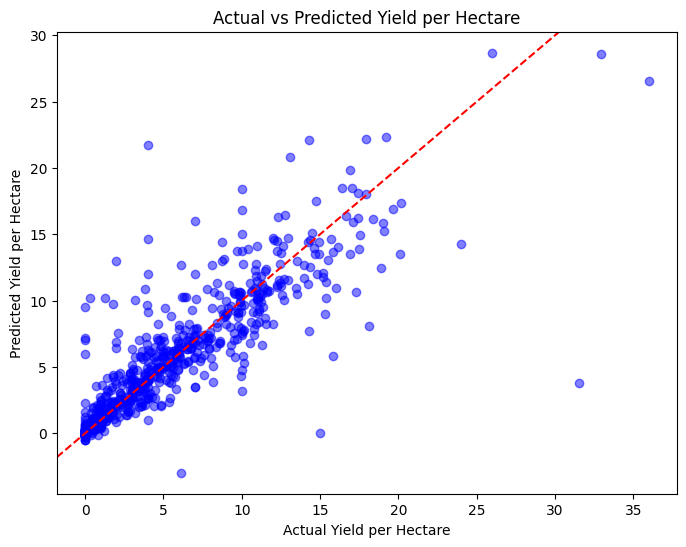

In [83]:
# Actual vs. Predicted Yield (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.xlabel("Actual Yield per Hectare")
plt.ylabel("Predicted Yield per Hectare")
plt.title("Actual vs Predicted Yield per Hectare")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.show()

In [155]:
# Define the objective function
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)

    # Use cross-validation or a validation set to evaluate the model
    score = model.score(X_test, y_test)  # R² score as an example
    return score

In [158]:
import optuna
# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

D:\git_repos\farm_mate\farm_mate_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-30 11:58:16,987] A new study created in memory with name: no-name-957a3a28-7b2f-4330-90b3-eb812a35874b
[I 2025-03-30 11:58:17,336] Trial 0 finished with value: 0.784973844218111 and parameters: {'max_depth': 11, 'learning_rate': 0.04146928231220161, 'n_estimators': 427, 'subsample': 0.7935554930309657, 'colsample_bytree': 0.9865235450274292, 'gamma': 0.29624562135815335, 'reg_alpha': 0.6111521375621974, 'reg_lambda': 0.1129784809777018}. Best is trial 0 with value: 0.784973844218111.
[I 2025-03-30 11:58:17,445] Trial 1 finished with value: 0.7844732513828631 and parameters: {'max_depth': 9, 'learning_rate': 0.06668868514520615, 'n_estimators': 109, 'subsample': 0.8808240195587983, 'colsample_bytree': 0.8311744055797678,

Best Parameters: {'max_depth': 12, 'learning_rate': 0.02989727011628024, 'n_estimators': 200, 'subsample': 0.7299704812203343, 'colsample_bytree': 0.9989498247636516, 'gamma': 0.20927844169254786, 'reg_alpha': 0.784902730797988, 'reg_lambda': 0.8658760784145385}


In [160]:
# Initialize the model with the best parameters
xgb_model = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42  # Ensure reproducibility
)
# Train the model with training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9989498247636516, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.20927844169254786, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02989727011628024,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...)

In [161]:
# Predict with the model on test data
y_pred = xgb_model.predict(X_test)

In [162]:
# Evaluate model
#mae
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 1.16


In [163]:
#mse
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 5.39


In [164]:
#r2
r2 = r2_score(y_test, y_pred)
print(f"R Squared Error: {r2:.2f}")

R Squared Error: 0.80


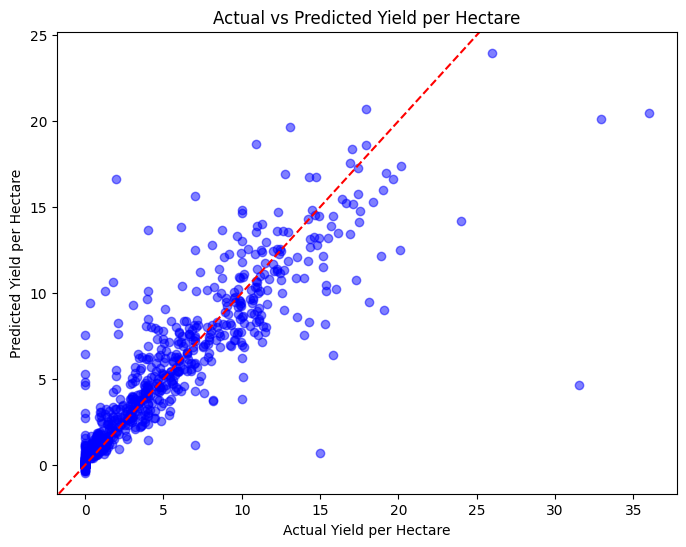

In [165]:
# Actual vs. Predicted Yield (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.xlabel("Actual Yield per Hectare")
plt.ylabel("Predicted Yield per Hectare")
plt.title("Actual vs Predicted Yield per Hectare")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.show()

In [166]:
# Save the model to a file
xgb_model.save_model("xgboost_model.json")

In [ ]:
#----------------------code to predict with saved model-------------------------------

In [6]:
import xgboost as xgb
import pickle
import numpy as np

In [7]:
# Load the encoders
with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

In [8]:
# loading the model
loaded_model = xgb.XGBRegressor() 
loaded_model.load_model("xgboost_model.json")

In [9]:
# Function to predict yield for a given input
def predict_yield(crop, year, season, district, area_hectares):
    """Predicts total production for a given crop, season, district, and area in hectares."""
    crop_encoded = label_encoders['Crop'].transform([crop])[0]
    season_encoded = label_encoders['Season'].transform([season])[0]
    district_encoded = label_encoders['District'].transform([district])[0]
    
    # Predict yield per hectare
    yield_per_hectare = loaded_model.predict(np.array([[crop_encoded, year, season_encoded, district_encoded, area_hectares]]))[0]
    
    # Calculate total production
    total_production = yield_per_hectare * area_hectares
    return total_production

In [12]:
# Example Prediction
predicted_production = predict_yield("Tomato", 2025, "Yala", "Colombo", 1)
print(f"Predicted Production for 1 hectares: {predicted_production:.2f} metric tons")

Predicted Production for 1 hectares: 5.17 metric tons
